# Implementation and Validation
The purpose of this section is to present out understanding of the code that implements the ADS. Our goal is to understand the implementation at a high-level and be able to speak to data cleaning and pre-processings, implementation of the system as well as its validation.  Ultimately, we would like to understand if the ADS was able to meets its stated goals.


## Importing Raw Data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.ticker as mtick
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

train_df = pd.read_csv('../data/aug_train.csv')
display(train_df.head())
print(train_df.shape)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


(19158, 14)


## Data Pre-processing

In [2]:
train_df['last_new_job'] = train_df['last_new_job'].apply(lambda x: 'Never' if x == 'never' else x) #just reads nicer
train_df['enrolled_university'][train_df['enrolled_university'] == 'no_enrollment'] = 'No Enrollment' #just reads nicer
train_df['company_size'] = train_df['company_size'].apply(lambda x: '10-49' if x == '10/49' else x) #diff replacement method

train_df['experience'] = train_df['experience'].apply(lambda x: '0' if x == '<1' else x)
train_df['experience'] = train_df['experience'].apply(lambda x: '20' if x == '>20' else x)

train_df['company_size'].fillna('0',inplace=True)
train_df['company_type'].fillna('Unknown',inplace=True)
train_df['major_discipline'].fillna('Unknown',inplace=True)
train_df['gender'].fillna('Not provided',inplace=True)

/Users/clairest-donat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
# Check for missing values - there should be far fewer after imputation
train_df.isnull().mean()

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.000000
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.000000
experience                0.003393
company_size              0.000000
company_type              0.000000
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [4]:
## Now we drop the remainder of the missing values
train_df.dropna(inplace=True)
print(train_df.shape)
print(train_df.isna().mean())

(18014, 14)
enrollee_id               0.0
city                      0.0
city_development_index    0.0
gender                    0.0
relevent_experience       0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
training_hours            0.0
target                    0.0
dtype: float64


In [5]:
# Converting objects to integers
train_df['experience'] = train_df['experience'].astype(str).astype(int)
train_df['training_hours'] = train_df['training_hours'].astype(str).astype(int)

In [6]:
## Save this dataset for later
output_df = train_df.copy(deep=True)

The creators repeated these pre-processing steps for the testing dataset as well and confirmed that the distributions of features between the datasets were similar.

## Feature Preparation

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.svm import LinearSVC
from imblearn.over_sampling import BorderlineSMOTE
from numpy import where

In [8]:
list_of_columns = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level',
                   'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

train_df_dummies = []

for col in list_of_columns:
    dummy_train_df = pd.get_dummies(train_df[col])
    train_df_dummies.append(dummy_train_df)


list_of_columns.append('enrollee_id')    
train_df_dummies.insert(0, train_df.drop(columns=list_of_columns))

train_df = pd.concat(train_df_dummies,axis=1)

# Final look at our df
train_df.head(3)

,city_development_index,training_hours,target,city_1,city_10,city_100,city_101,city_102,city_103,city_104,...,Other,Public Sector,Pvt Ltd,Unknown,1,2,3,4,>4,Never
0,0.920,36,1.0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
1,0.776,47,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0.624,83,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## Modeling

In [9]:
X = train_df.dropna().drop(columns=['target']).values
y = train_df.dropna()['target'].values
indices = train_df.index

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.3, random_state=80)

In [10]:
# Classification with a linear SVM
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10 ** k for k in range(-3, 4)]}
clf = GridSearchCV(svc, params_grid)
clf.fit(X_train, y_train)
print(
    "Accuracy on the test set with raw data: {:.3f}".format(clf.score(X_test, y_test))
)

print(clf.best_params_)

Accuracy on the test set with raw data: 0.784
{'C': 0.1}


In [11]:
# Support Vector Machine (SVM / SVC)
pipeline = make_pipeline(StandardScaler(), SVC(kernel='sigmoid'))
pipeline.fit(X_train, y_train)
svc_prediction = pipeline.predict(X_test)
cm_svc = confusion_matrix(y_test, svc_prediction)
svc_df = pd.DataFrame(data=[accuracy_score(y_test, svc_prediction), recall_score(y_test, svc_prediction),
                   precision_score(y_test, svc_prediction), roc_auc_score(y_test, svc_prediction)], 
             columns=['SVC Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [12]:
# Basic Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dtree_prediction = dtree.predict(X_test)
cm_dtree = confusion_matrix(y_test, dtree_prediction)
dtree_df = pd.DataFrame(data=[accuracy_score(y_test, dtree_prediction), recall_score(y_test, dtree_prediction),
                   precision_score(y_test, dtree_prediction), roc_auc_score(y_test, dtree_prediction)], 
             columns=['Decision Tree Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [13]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
rfc_prediction = rfc.predict(X_test)
cm_rfc = confusion_matrix(y_test, rfc_prediction)
rfc_df = pd.DataFrame(data=[accuracy_score(y_test, rfc_prediction), recall_score(y_test, rfc_prediction),
                   precision_score(y_test, rfc_prediction), roc_auc_score(y_test, rfc_prediction)], 
             columns=['Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [14]:
# Code for Hyper Parameter Tuning
#param_grid = { 
#    'n_estimators': [ 500,800],
#    'max_features': ['auto', 'sqrt'],
#    'max_depth' : [7,8,9],
#    'criterion' :['gini', 'entropy']
#}

#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train,y_train)
#CV_rfc.best_params_

# Tuned Random Forest
rfc1=RandomForestClassifier(random_state=0, n_estimators= 800, criterion = 'gini',max_features = 'auto',max_depth = 8)
rfc1.fit(X_train,y_train)
prediction_rf1= rfc1.predict(X_test)
cm_trfc = confusion_matrix(y_test, prediction_rf1)
trfc_df = pd.DataFrame(data=[accuracy_score(y_test, prediction_rf1), recall_score(y_test, prediction_rf1),
                   precision_score(y_test, prediction_rf1), roc_auc_score(y_test, prediction_rf1)], 
             columns=['Tuned Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [15]:
#Logistic Regression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
log_prediction = logmodel.predict(X_test)
cm_log = confusion_matrix(y_test, log_prediction)
log_df = pd.DataFrame(data=[accuracy_score(y_test, log_prediction), recall_score(y_test, log_prediction),
                   precision_score(y_test, log_prediction), roc_auc_score(y_test, log_prediction)], 
             columns=['Logisitc Regression Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

/Users/clairest-donat/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [16]:
# Scale Features
scaler = StandardScaler()
scaler.fit(train_df.drop('target',axis=1))
scaled_features = scaler.transform(train_df.drop('target',axis=1))

# re split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,train_df['target'],
                                                    test_size=0.30, random_state=80)

# K-Nearest Neighbours (KNN)
# searched already to find optimal neighbours, removed from notebook as took a long time
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train)
knn_prediction = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, knn_prediction)
knn_df = pd.DataFrame(data=[accuracy_score(y_test, knn_prediction), recall_score(y_test, knn_prediction),
                   precision_score(y_test, knn_prediction), roc_auc_score(y_test, knn_prediction)], 
             columns=['KNN Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

/Users/clairest-donat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/clairest-donat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


### Check Results Prematurely

/Users/clairest-donat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


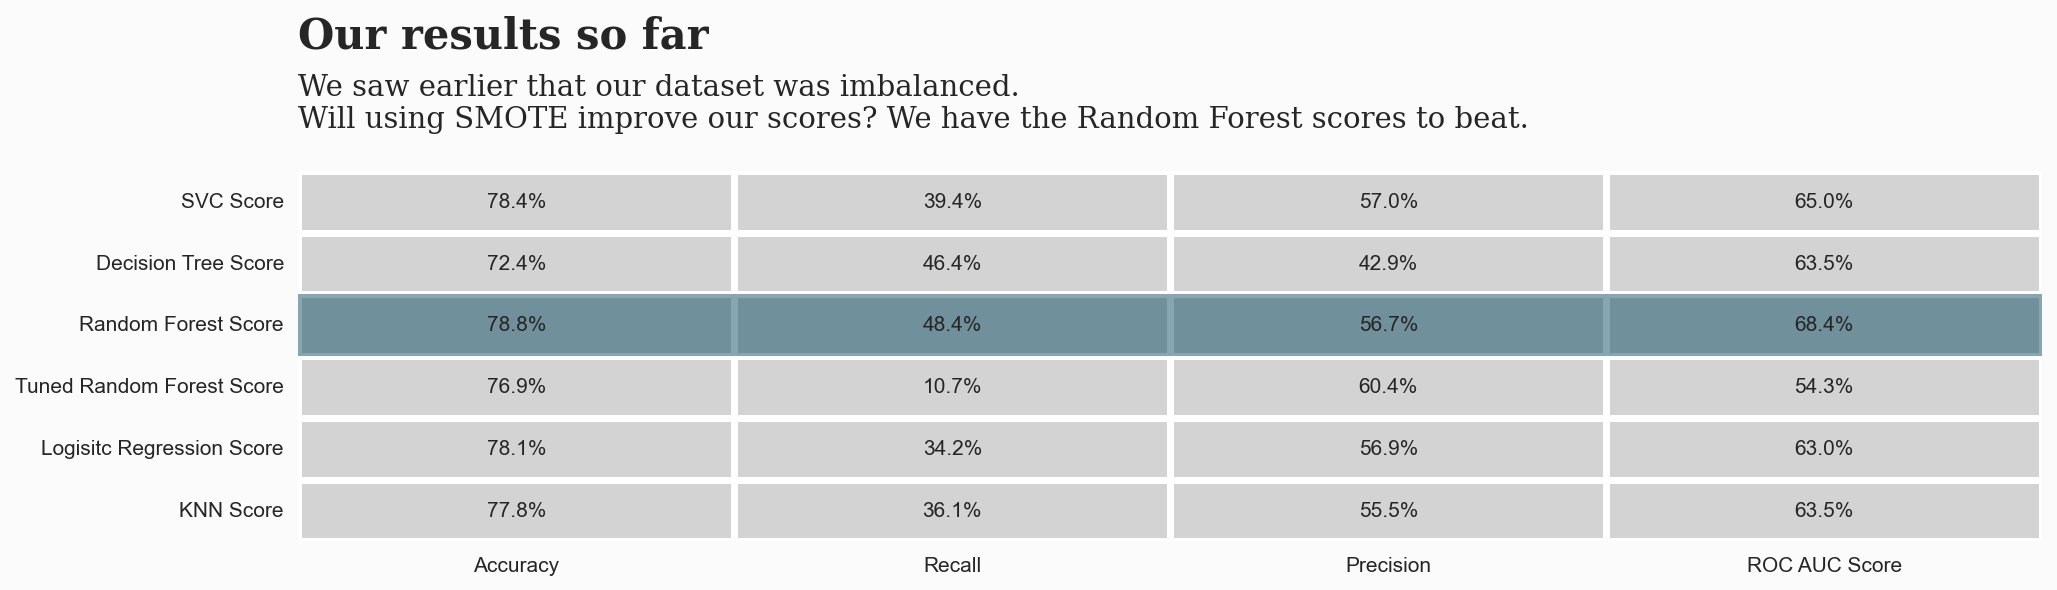

In [17]:
fig = plt.figure(figsize=(15,18), dpi=150)
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

colors = ["lightgray","lightgray"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

# Overall
df_models = round(pd.concat([svc_df,dtree_df,rfc_df,trfc_df,log_df,knn_df], axis=1),3)
sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax0)

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax0.text(0,-2,'Our results so far',fontfamily='serif',fontsize=20,fontweight='bold')
ax0.text(0,-0.7,'We saw earlier that our dataset was imbalanced.\nWill using SMOTE improve our scores? We have the Random Forest scores to beat.',fontfamily='serif',fontsize=14)

from matplotlib.patches import Rectangle

rect = ax0.add_patch(Rectangle((0, 2), 5, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))

plt.show()

## Implementing SMOTE
SMOTE is a technique that helps deal with imbalanced data sets.

A great introductory article can be found here:

https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/

The common error I see people making is to use SMOTE and THEN split their data in to train & test sets. This is a big mistake as you will get some serious data leakage and end up predicting synthetic results that you have just created - it does not make sense.

Instead, split your data first, and THEN use SMOTE on the training data only.

Let's see if it helps here...

In [18]:
from imblearn.over_sampling import SMOTE

X = train_df.dropna().drop(columns=['target']).values
y = train_df.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)

oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

In [19]:
# Scale our data in pipeline
rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])

In [20]:
#rf_cv = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
#svm_cv = cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
#logreg_cv = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')

print('Mean f1 scores:')
print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
# removed svm as took an incredibly long time to fit
#print('SVM mean :',cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('Logistic Regression mean :',cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())

Mean f1 scores:
Random Forest mean : 0.8309234070359686
Logistic Regression mean : 0.7862513619097362


On the training dataset, the model is performing well. Now we'll try on the test dataset.

In [21]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

rf_pipeline.fit(X_train_resh,y_train_resh)
#svm_pipeline.fit(X_train_resh,y_train_resh)
logreg_pipeline.fit(X_train_resh,y_train_resh)

rf_pred   =rf_pipeline.predict(X_test)
#svm_pred  = svm_pipeline.predict(X_test)
logreg_pred   = logreg_pipeline.predict(X_test)

rf_cm  = confusion_matrix(y_test,rf_pred )
#svm_cm = confusion_matrix(y_test,svm_pred)
logreg_cm  = confusion_matrix(y_test,logreg_pred )

rf_f1  = f1_score(y_test,rf_pred)
#svm_f1 = f1_score(y_test,svm_pred)
logreg_f1  = f1_score(y_test,logreg_pred)

In [22]:
print('Mean scores:')
print('RF F1 score:',rf_f1)
print('RF Accuracy:',accuracy_score(y_test,rf_pred))
print('LR F1 score :',logreg_f1)
print('LR Accuracy:',accuracy_score(y_test,logreg_pred))

Mean scores:
RF F1 score: 0.5370823145884271
RF Accuracy: 0.7898242368177614
LR F1 score : 0.605412208936438
LR Accuracy: 0.7679925994449583


The results look very good so far.  Let's view them side-by-side so we can select the model that best achieves our aims.

In [23]:
smote_rf_df = pd.DataFrame(data=[accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                   precision_score(y_test, rf_pred), roc_auc_score(y_test, rf_pred)], 
             columns=['SMOTE Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

smote_logreg_df = pd.DataFrame(data=[accuracy_score(y_test, logreg_pred), recall_score(y_test, logreg_pred),
                   precision_score(y_test, logreg_pred), roc_auc_score(y_test, logreg_pred)], 
             columns=['SMOTE Logistic Regression Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])


smote_cm_log = confusion_matrix(y_test, logreg_pred)
smote_cm_rf = confusion_matrix(y_test, rf_pred)


/Users/clairest-donat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/clairest-donat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


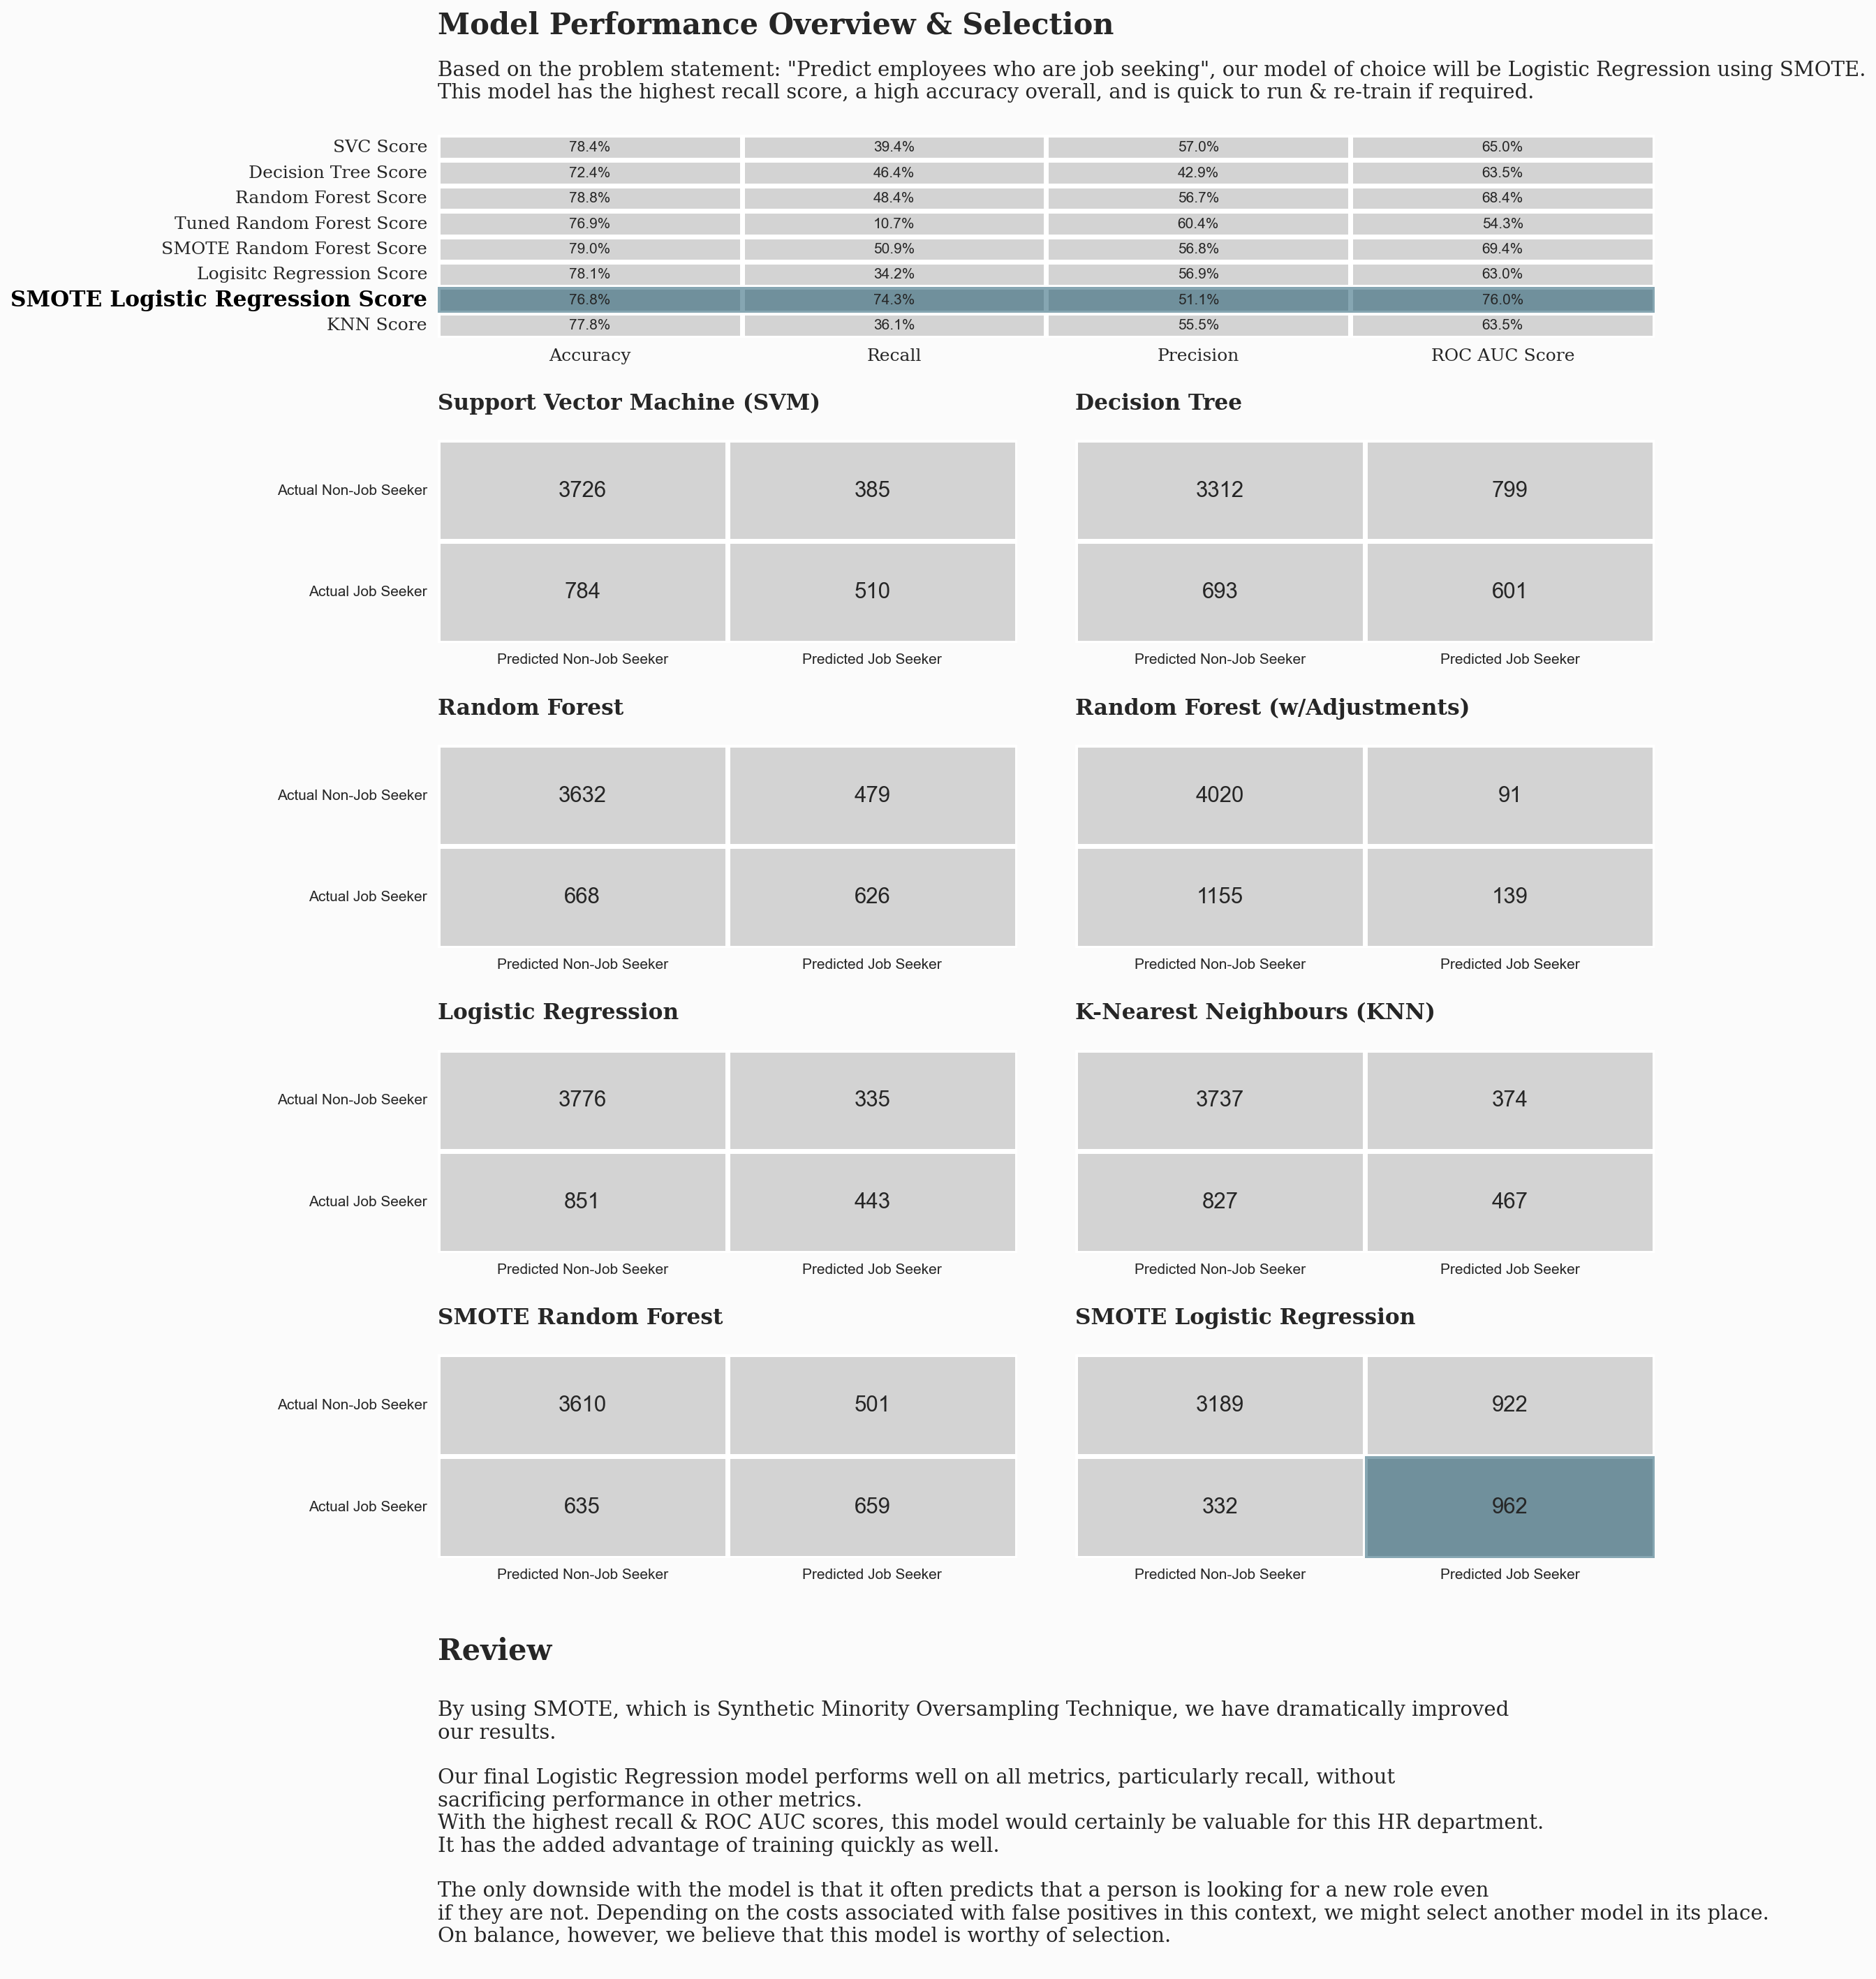

In [24]:
# Plotting our results

colors = ["lightgray","lightgray"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(15,18), dpi=150) # create figure
gs = fig.add_gridspec(5, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 0])
ax6 = fig.add_subplot(gs[3,1])
ax7 = fig.add_subplot(gs[4,0])
ax8 = fig.add_subplot(gs[4,1])

# Overall
df_models = round(pd.concat([svc_df,dtree_df,rfc_df,trfc_df,smote_rf_df,log_df,smote_logreg_df,knn_df], axis=1),3)
sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax0)


ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=12)
ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=0, fontsize=12)

ax0.text(0,-4,'Model Performance Overview & Selection',fontfamily='serif',fontsize=20,fontweight='bold')
ax0.text(0,-0.55,
         '''
Based on the problem statement: "Predict employees who are job seeking", our model of choice will be Logistic Regression using SMOTE.
This model has the highest recall score, a high accuracy overall, and is quick to run & re-train if required.
'''
         ,fontfamily='serif',fontsize=14)

for lab, annot in zip(ax0.get_yticklabels(), ax0.texts):
    text =  lab.get_text()
    if text == 'SMOTE Logistic Regression Score': 
        # set the properties of the ticklabel
        lab.set_weight('bold')
        lab.set_size(15)
        lab.set_color('black')

from matplotlib.patches import Rectangle

rect = ax0.add_patch(Rectangle((0, 6), 5, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))


# svc
sns.heatmap(cm_svc, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax1,annot_kws={"fontsize":15})

# dtree
sns.heatmap(cm_dtree, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax2,annot_kws={"fontsize":15})

# rf
sns.heatmap(cm_rfc, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax3,annot_kws={"fontsize":15})

# tuned rf
sns.heatmap(cm_trfc, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax4,annot_kws={"fontsize":15})

# log
sns.heatmap(cm_log, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax5,annot_kws={"fontsize":15})

# knn
sns.heatmap(cm_knn, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax6,annot_kws={"fontsize":15})

# smote rf
sns.heatmap(smote_cm_rf, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax7,annot_kws={"fontsize":15})

# smote log reg
sns.heatmap(smote_cm_log, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax8,annot_kws={"fontsize":15})

background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) 

ax0.set_xlabel("")
ax0.set_ylabel("")


ax1.text(0, -0.3, 'Support Vector Machine (SVM)',fontsize=15, fontweight='bold', fontfamily='serif')
ax2.text(0, -0.3, 'Decision Tree', fontsize=15, fontweight='bold', fontfamily='serif')
ax3.text(0, -0.3, 'Random Forest',fontsize=15, fontweight='bold', fontfamily='serif')
ax4.text(0, -0.3, 'Random Forest (w/Adjustments)', fontsize=15, fontweight='bold', fontfamily='serif')
ax5.text(0, -0.3, 'Logistic Regression',fontsize=15, fontweight='bold', fontfamily='serif')
ax6.text(0, -0.3, 'K-Nearest Neighbours (KNN)', fontsize=15, fontweight='bold', fontfamily='serif')
ax7.text(0, -0.3, 'SMOTE Random Forest',fontsize=15, fontweight='bold', fontfamily='serif')
ax8.text(0, -0.3, 'SMOTE Logistic Regression', fontsize=15, fontweight='bold', fontfamily='serif')

ax7.text(0, 3, 'Review',fontsize=20, fontweight='bold', fontfamily='serif')
ax7.text(0, 6, 
'''
By using SMOTE, which is Synthetic Minority Oversampling Technique, we have dramatically improved
our results.

Our final Logistic Regression model performs well on all metrics, particularly recall, without
sacrificing performance in other metrics.
With the highest recall & ROC AUC scores, this model would certainly be valuable for this HR department.
It has the added advantage of training quickly as well.

The only downside with the model is that it often predicts that a person is looking for a new role even
if they are not. Depending on the costs associated with false positives in this context, we might select another model in its place.
On balance, however, we believe that this model is worthy of selection.
''',fontsize=14, fontfamily='serif')

from matplotlib.patches import Rectangle


ax8.add_patch(Rectangle((1, 1), 1, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))

colors = ['gray','#0e4f66','#002d1d']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

for i in range(0,9):
    locals()["ax"+str(i)].set_facecolor(background_color) 
    
for i in range(0,9):
    locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)


for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)

plt.show()

## Ouput
Finally, we output the results of the chosen model to a flat file for later use.

In [26]:
predicted_output = output_df.loc[idx_test]
# Quick check to make sure that both dataframes are the same
display(predicted_output[predicted_output.target != y_test])

predicted_output['prediction'] = logreg_pred

predicted_output.to_csv('../data/ADS_output.csv', index = False)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
